In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch
import numpy as np
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
from utils import *
import cv2
import os
import seaborn as sns
from collections import Counter
%matplotlib inline

In [2]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
prep_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Load caltech256 dataset

In [4]:
dataset = datasets.ImageFolder("./data/256_ObjectCategories/")

In [ ]:
dataset.classes

In [6]:
num_classes  = len(dataset.classes)

In [7]:
print(num_classes), print("Total images:", len(dataset))

257
Total images: 30607


(None, None)

In [8]:
labels = [label for _, label in dataset.samples]
train_indices, test_indices = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [9]:
class_names = dataset.classes

In [10]:
class_counts = Counter(dataset.targets)

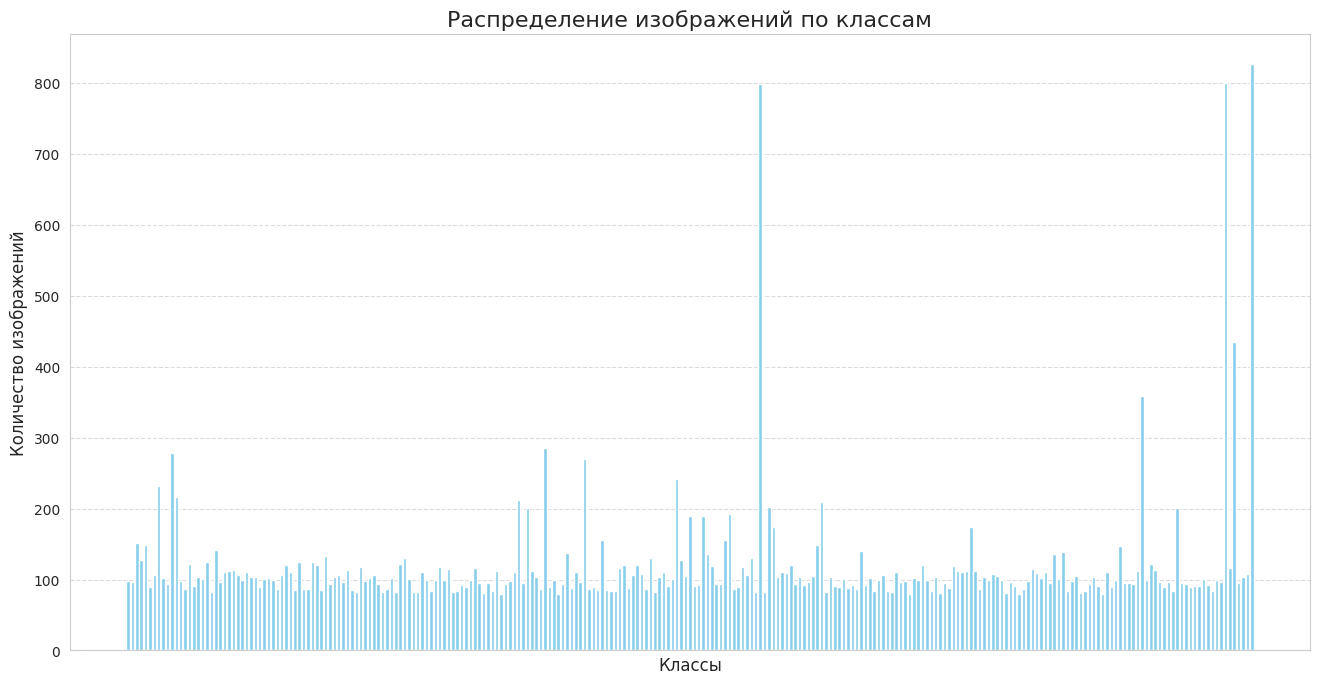

In [11]:
plt.figure(figsize=(16, 8))
counts = [class_counts[i] for i in range(len(class_names))]
plt.bar(range(len(class_names)), counts, color='skyblue')
plt.title('Распределение изображений по классам', fontsize=16)
plt.xlabel('Классы', fontsize=12)
plt.ylabel('Количество изображений', fontsize=12)
plt.xticks([]) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

Распеделение классов можно было бы назвать равномерным, за исключением 4

In [12]:
len(labels)

30607

In [13]:
min(labels), max(labels)

(0, 256)

In [14]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomAffine(
        degrees=0, 
        translate=(0.15, 0.15),  
        scale=(0.8, 1.2),        
        shear=15                 
    ),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img = self.transform(img)
        return img, label
        
    def __len__(self):
        return len(self.subset)

# Создаем подмножества с разными трансформациями
train_dataset = TransformSubset(
    Subset(dataset, train_indices),
    transform=train_transform
)
test_dataset = TransformSubset(
    Subset(dataset, test_indices),
    transform=test_transform
)

In [16]:
print(f"Train volume: {len(train_dataset)}")
print(f"Test volume: {len(test_dataset)}")

Train volume: 24485
Test volume: 6122


In [17]:
BATCH_SIZE = 128

In [18]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

### Sanity check

In [19]:
img, label = test_dataset[2]

In [20]:
img.shape

torch.Size([3, 224, 224])

In [21]:
type(test_dataset), type(train_dataset)

(__main__.TransformSubset, __main__.TransformSubset)

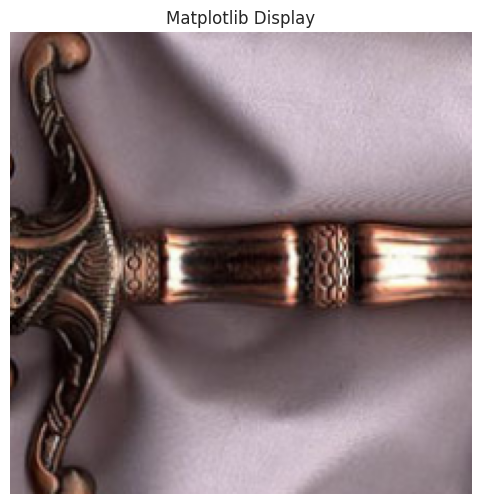

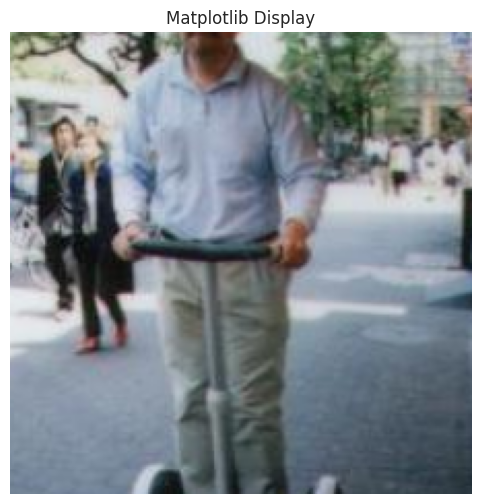

In [22]:
for images, labels in test_loader:
    image = images[0]
    show_tensor_as_image(image)
    image = images[1] 
    show_tensor_as_image(image)
    break

### Model

In [20]:
model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
num_ftrs = model.fc.in_features
hidden_dim = num_ftrs*2
# Замораживаем начальные слои
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
    nn.Dropout(0.2),  
    nn.Linear(num_ftrs, hidden_dim),
    nn.Dropout(0.2), 
    nn.Linear(hidden_dim, num_classes)
)
model = model.to(device)

In [21]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Train stage

Здесь  разморожены оригинальный layer4 и изменённый fc. fc небольшая, так  AdaptiveAvgPool2d перед этим

In [22]:
unfreeze_layers = ['layer4', 'fc']  # Только последний блок и классификатор
for name, param in model.named_parameters():
    if any(layer in name for layer in unfreeze_layers):
        param.requires_grad = True

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            precision, recall, f1, _ = precision_recall_fscore_support(
                all_labels, all_preds, average='macro', zero_division=0
            )
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print(f'Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}')

            if phase == 'test' and f1 > best_f1:
                best_f1 = f1
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best test f1: {best_f1:.4f}')
    model.load_state_dict(best_model_wts)
    return model

In [24]:
learning_rate = 0.001
num_epochs = 50

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate,weight_decay=5e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [26]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 2.6785 Acc: 0.4090
Precision: 0.3681 Recall: 0.3498 F1: 0.3529
test Loss: 1.8804 Acc: 0.5546
Precision: 0.6108 Recall: 0.5092 F1: 0.4942
Epoch 1/49
----------
train Loss: 1.7324 Acc: 0.5852
Precision: 0.5482 Recall: 0.5439 F1: 0.5444
test Loss: 1.5550 Acc: 0.6325
Precision: 0.6863 Recall: 0.5916 F1: 0.5850
Epoch 2/49
----------
train Loss: 1.4428 Acc: 0.6464
Precision: 0.6161 Recall: 0.6123 F1: 0.6128
test Loss: 1.4745 Acc: 0.6619
Precision: 0.6996 Recall: 0.6248 F1: 0.6230
Epoch 3/49
----------
train Loss: 1.2693 Acc: 0.6805
Precision: 0.6565 Recall: 0.6498 F1: 0.6520
test Loss: 1.5407 Acc: 0.6658
Precision: 0.7134 Recall: 0.6307 F1: 0.6272
Epoch 4/49
----------
train Loss: 1.1632 Acc: 0.7063
Precision: 0.6859 Recall: 0.6788 F1: 0.6814
test Loss: 1.3560 Acc: 0.7014
Precision: 0.7183 Recall: 0.6712 F1: 0.6669
Epoch 5/49
----------
train Loss: 1.0562 Acc: 0.7318
Precision: 0.7140 Recall: 0.7068 F1: 0.7095
test Loss: 1.3246 Acc: 0.7070
Precision: 0.7347 

По метрикам  видно переобучение, начиная с 25 эпохи, и можно было бы поставить ёрли-стоп, но по макс точности она и так взяла лучшее(метрики в макро):
test Loss: 1.4459 Acc: 0.7507
Precision: 0.7597 Recall: 0.7244 F1: 0.7266
Epoch 22/49

### visualization

In [ ]:
class_names = dataset.classes

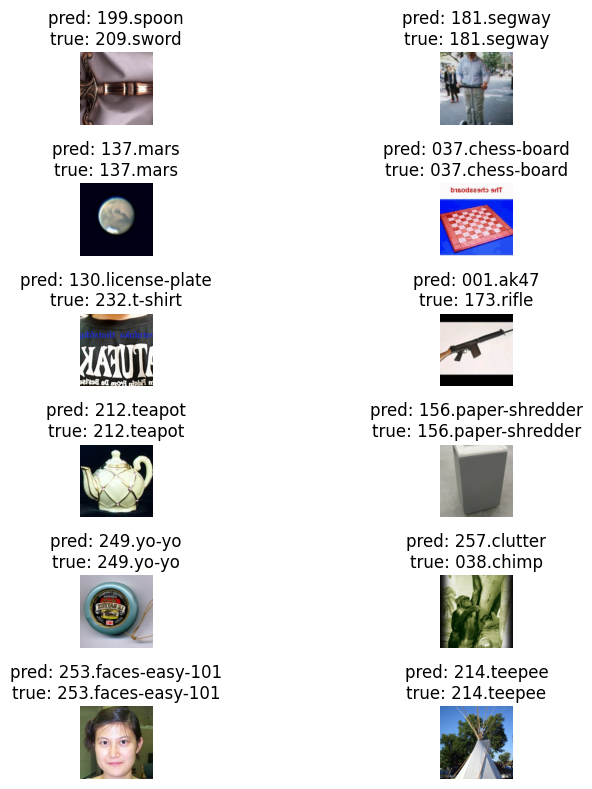

In [31]:
def visualize_predictions(model, num_images=12):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 8))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}')
                img = inputs.cpu().data[j].permute(1, 2, 0).numpy()
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Денормализация
                plt.imshow(np.clip(img, 0, 1))
                
                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return

visualize_predictions(model)

Видно,что перепутала ложку с мечом. Но это из-за ресайза и кропа так обрезался меч, также тяжело различает близкие классы. Например, ак-47 и рифл  

### YOLO

In [33]:
from ultralytics import YOLO
model = YOLO("yolo11n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/student/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100.0%


In [36]:
image_path_test = "./data/256_ObjectCategories/060.duck/060_0004.jpg"

In [37]:
results = model([image_path_test])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk


0: 448x640 2 birds, 52.7ms
Speed: 4.5ms preprocess, 52.7ms inference, 100.0ms postprocess per image at shape (1, 3, 448, 640)


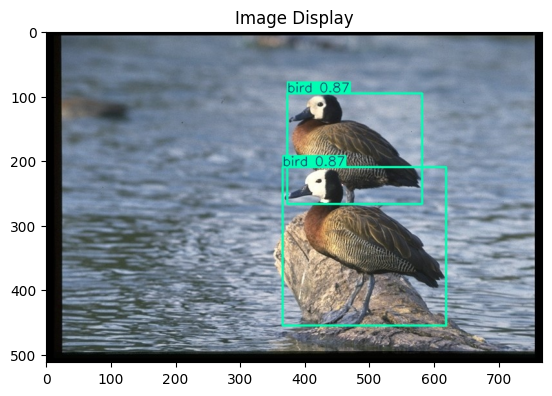

In [41]:
plt.imshow(plt.imread("result.jpg"))
plt.title('Image Display')
plt.show()

### Fintune YOLO

https://www.kaggle.com/datasets/itsmeaman03/fruit-detection-yolo - датасет отсюда

In [43]:
images_path = './data/fruit-detection-dataset/fruit-detection-dataset/images/train'
labels_path = './data/fruit-detection-dataset/fruit-detection-dataset/labels/train'
output_folder = 'checked_images'
os.makedirs(output_folder, exist_ok=True)
color_border = (255, 0, 0)

### Check boxing

In [44]:
images = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

In [45]:
def denormalize_coordinates(x_center, y_center, width, height, img_width, img_height):
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)
    return x1, y1, x2, y2

In [ ]:
for image_file in images:
    image_path = os.path.join(images_path, image_file)
    label_file = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(labels_path, label_file)

    if not os.path.exists(label_path):
        print(f"Label file not found for image: {image_file}")
        continue

    image = cv2.imread(image_path)
    img_height, img_width = image.shape[:2]

    with open(label_path, 'r') as f:
        for line in f:
            cls, x_center, y_center, width, height = map(float, line.strip().split())
            x1, y1, x2, y2 = denormalize_coordinates(x_center, y_center, width, height, img_width, img_height)
            color = color_border
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f'class {int(cls)}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Сохранение изображения с нарисованными прямоугольниками
    output_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_path, image)
    print(f"Saved checked image: {output_path}")

print("Проверка разметки завершена.")

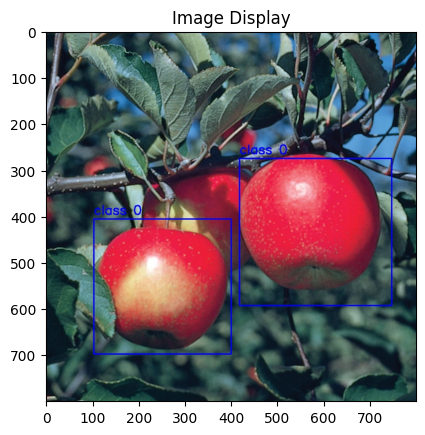

In [47]:
plt.imshow(plt.imread("./checked_images/apple_13.jpg"))
plt.title('Image Display')
plt.show()

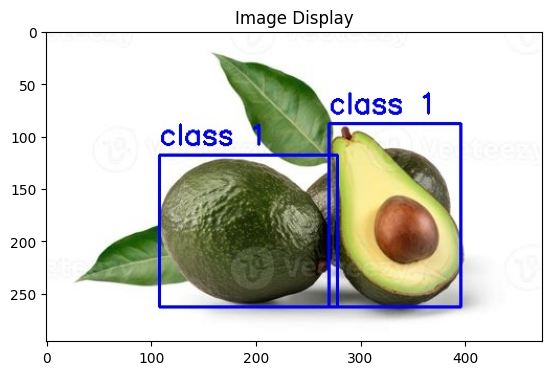

In [52]:
plt.imshow(plt.imread("./checked_images/Avacado-73.jpeg"))
plt.title('Image Display')
plt.show()

In [60]:
data_path = os.path.join("./data", 'data.yaml')
data_path

'./data/data.yaml'

In [61]:
epochs = 200
batch_size = 32

In [ ]:
results = model.train(data=data_path,
                  epochs=epochs, 
                  batch=batch_size, 
                  name='red',
                  device='cuda')

### Metrics

#### Dataset Info and  Train stage metrics

In [28]:
ref_path = "./runs/detect/red4/"

In [33]:
im_to_show =  list(map(lambda target: os.path.join(ref_path, target)  , ["labels.jpg", "results.png","F1_curve.png", "PR_curve.png"]))
im_to_show

['./runs/detect/red4/labels.jpg',
 './runs/detect/red4/results.png',
 './runs/detect/red4/F1_curve.png',
 './runs/detect/red4/PR_curve.png']

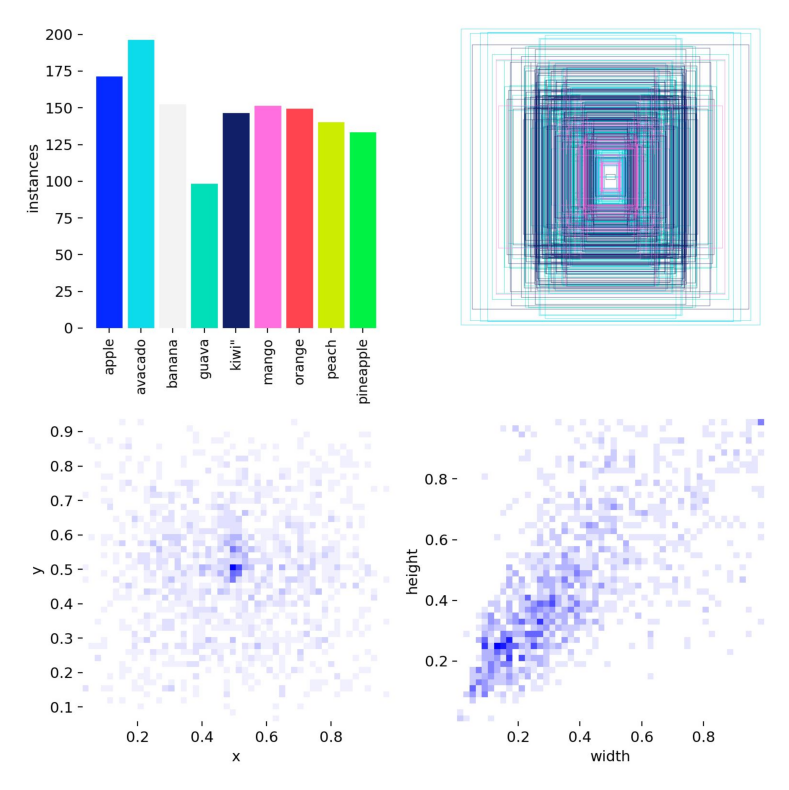

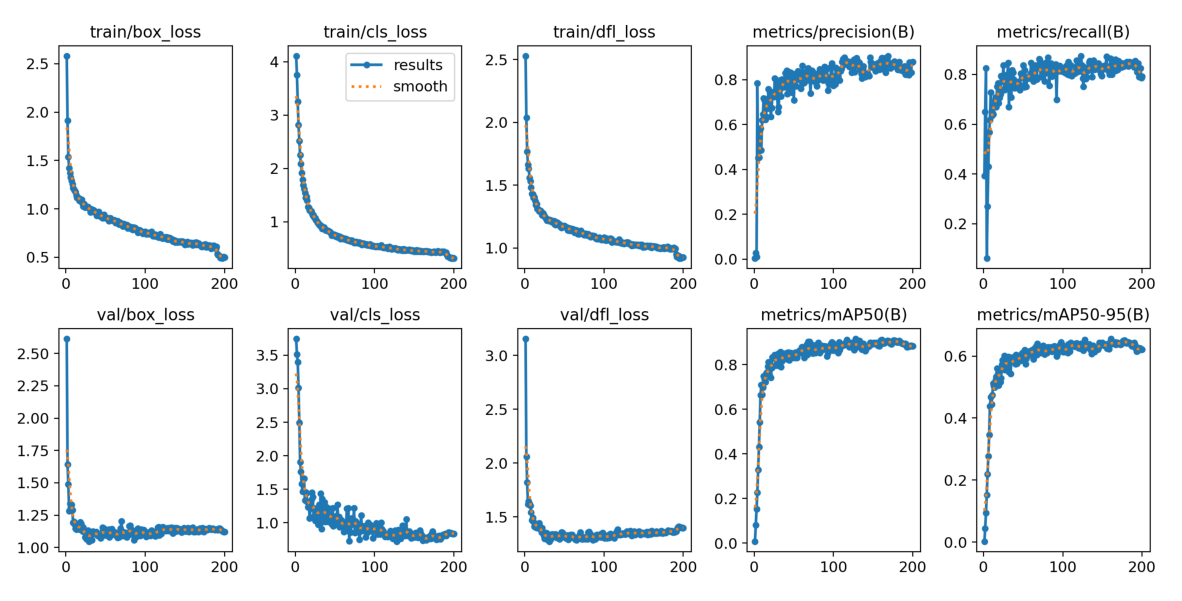

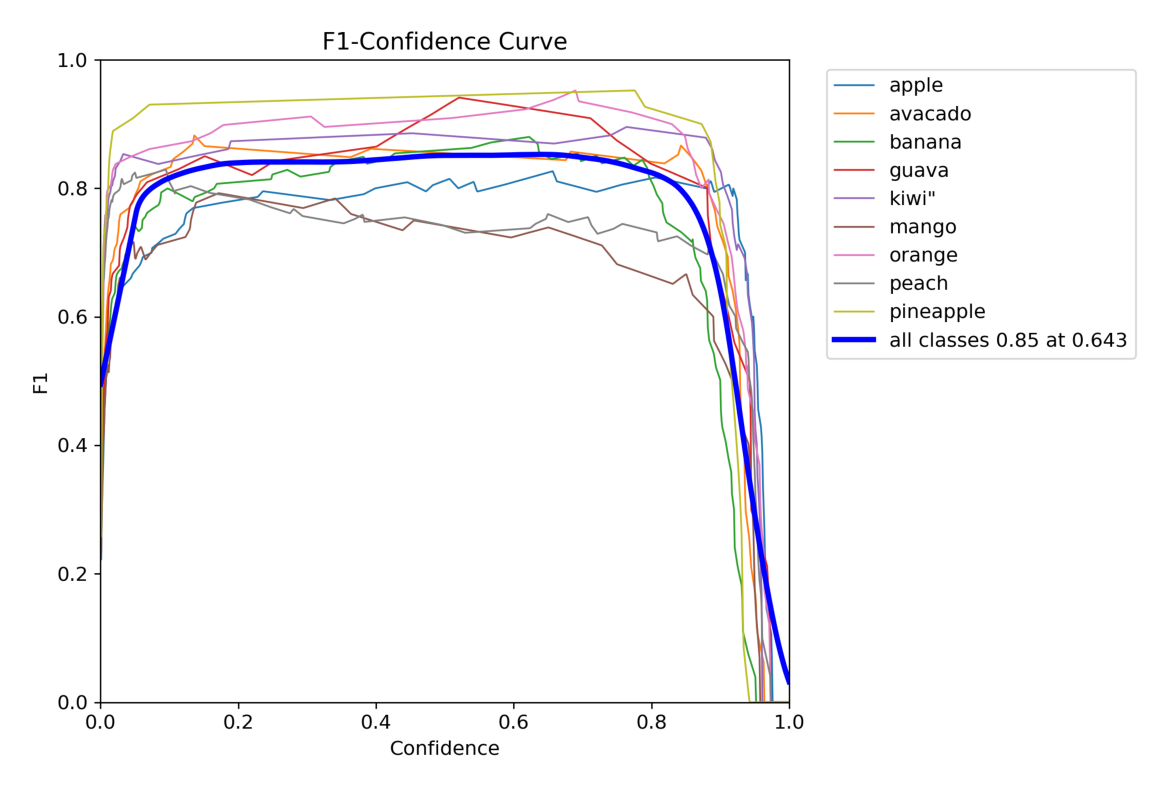

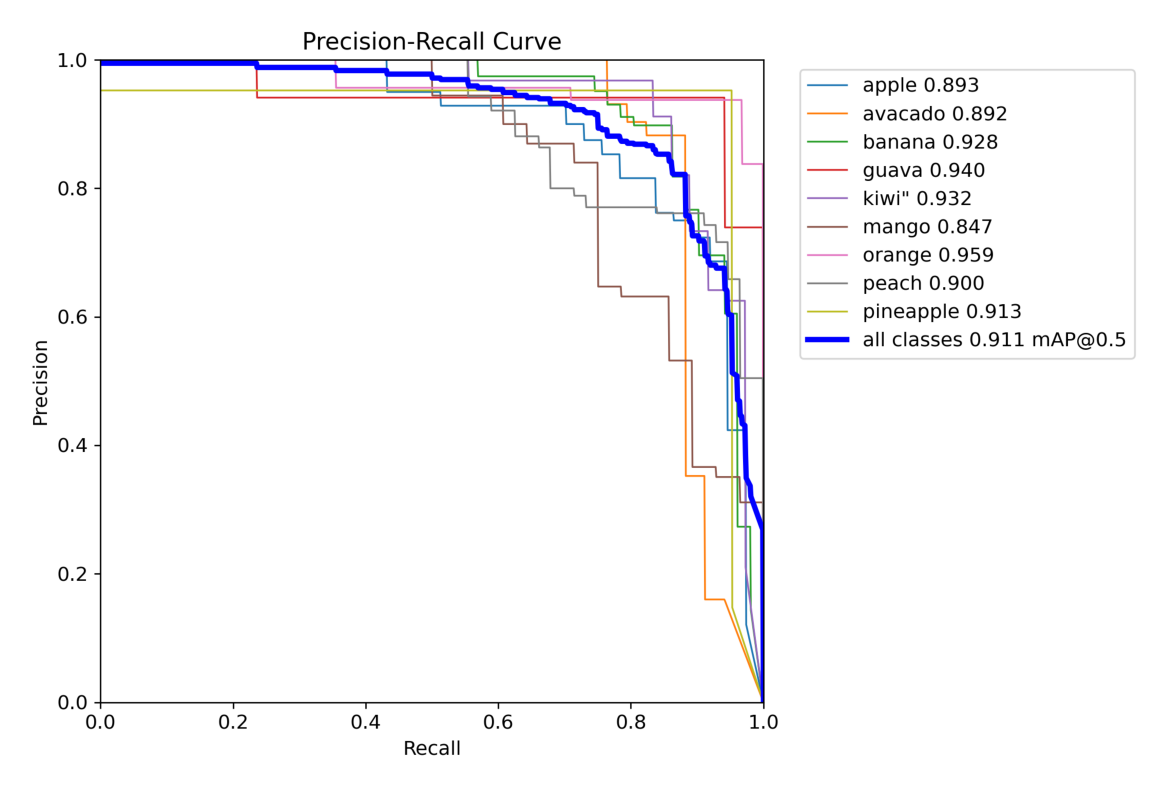

In [34]:

for path in im_to_show:
    plt.figure(figsize=(15, 10))
    plt.imshow(plt.imread(path))
    plt.axis('off')  # Отключаем оси
    plt.show()

Несмотря, что F1/confidence показывает f1 макро лучшее на уровне confidence = 0.643, на графике видим, что можно взять и на уровне 0.2,где меньшая дисперсия, пускай и f1 макро будет на уровне 0.82. На уровне confidence = 0.643 f1 макро выше за счёт классов, которые лежат выше среднего, но при этом те, которые лежат ниже, достаточно плохие

###  Visual test

In [68]:
MODEL_PATH = './runs/detect/red4/weights/best.pt' 
VIDEO_PATH = './data/video_test.mp4'
OUTPUT_PATH = 'yolo_detected.mp4' 
CONF_THRESH = 0.2
CLASSES = ["apple","avacado","banana","guava",'kiwi"',"mango","orange","peach","pineapple"]
COLORS = {
    'apple': (0, 0, 255),
    'avocado': (0, 128, 0),
    'banana': (0, 255, 255),
    'guava': (203, 192, 255),
    'kiwi': (0, 255, 0),
    'mango': (0, 165, 255),
    'orange': (0, 69, 255),
    'peach': (0, 200, 255),
    'pineapple': (0, 215, 255)
}

In [69]:
model = YOLO(MODEL_PATH)

In [70]:
from tqdm import tqdm

In [71]:
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError(f"Не удалось открыть видео: {VIDEO_PATH}")

# Получаем параметры видео
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Создаем VideoWriter для сохранения результата
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (width, height))

In [72]:
total_inference_time = 0

In [73]:
for _ in tqdm(range(total_frames), desc="Обработка видео"):
    ret, frame = cap.read()
    if not ret:
        break

    start_time = time.perf_counter()

    results = model.predict(
        source=frame,
        conf=CONF_THRESH,
        verbose=False
    )
    
    end_time = time.perf_counter()
    inference_time = end_time - start_time
    total_inference_time += inference_time
    
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            cls_id = int(box.cls)
            conf = float(box.conf)
            cls_name = CLASSES[cls_id]
            
            color = COLORS.get(cls_name, (0, 255, 0))
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            
            label = f"{cls_name}: {conf:.2f}"
            cv2.putText(
                frame, 
                label, 
                (x1, y1 - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.7, 
                color, 
                2
            )
    
    out.write(frame)


Обработка видео: 100%|██████████| 177/177 [00:04<00:00, 38.24it/s]


#### FPS average, GPU: A100 

In [76]:
print(f"FPS average:{total_frames / total_inference_time}" )


FPS average:47.26090344098656


In [63]:
cap.release()
out.release()

In [47]:
ref_path = "./data"

In [48]:
images_final_path=  list(map(lambda target: os.path.join(ref_path, target)  , ["all.jpeg", "bananas.jpg"]))

In [51]:
images = cv2.imread(images_final_path)
if images is None:
    raise FileNotFoundError(f"Не удалось загрузить изображение: {image_path}")

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'imread'
> Overload resolution failed:
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object


Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpd7hsiqth.PNG'


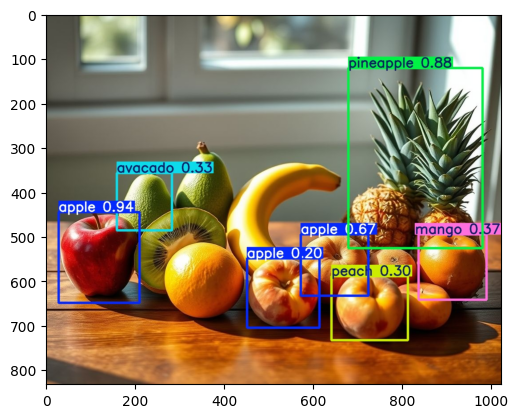

Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpwr352h_r.PNG'


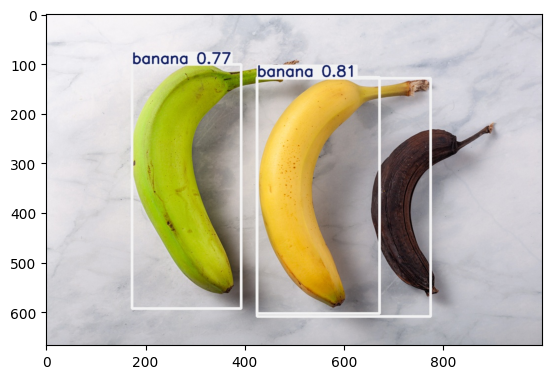

In [52]:
results = model.predict(
    source=images,
    conf=0.2,
    verbose=False  # Отключаем вывод в консоль
)
# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk
    plt.imshow(plt.imread("result.jpg"))
    plt.show()